In [1]:
%pip install pandas_ta
%pip install gdown

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
# import dukascopy_python
# from dukascopy_python.instruments import INSTRUMENT_FX_MAJORS_USD_CAD
import pandas_ta as ta
import matplotlib.pyplot as plt
import gdown

In [3]:
# Reading csv
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Final dataset - contains all features

file_id = '1LlfPyGGdGnAhliUo7lKEFIoQdWha1Dd2'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'final_dataset.csv'

# This handles the virus scan warning automatically
gdown.download(url, output, quiet=False)

# Now load the local file
df = pd.read_csv(output)

df.head()

Downloading...
From: https://drive.google.com/uc?id=1LlfPyGGdGnAhliUo7lKEFIoQdWha1Dd2
To: C:\Users\veere\Kavya\final_dataset.csv
100%|█████████████████████████████████████████████████████████████████████████████| 24.3M/24.3M [00:00<00:00, 57.3MB/s]


,timestamp,open,high,low,close,volume
0,2012-01-11 01:30:00+00:00,1.01794,1.01836,1.01794,1.01803,536.52
1,2012-01-11 01:45:00+00:00,1.01798,1.01798,1.01755,1.01789,763.57
2,2012-01-11 02:00:00+00:00,1.01789,1.01797,1.01742,1.01766,920.21
3,2012-01-11 02:15:00+00:00,1.01767,1.01794,1.01763,1.01780,739.82
4,2012-01-11 02:30:00+00:00,1.01780,1.01826,1.01780,1.01799,912.26


In [4]:
df.shape

(370390, 6)

In [5]:
# sorting by index
df.sort_index(inplace=True)

In [6]:
df.head()

,timestamp,open,high,low,close,volume
0,2012-01-11 01:30:00+00:00,1.01794,1.01836,1.01794,1.01803,536.52
1,2012-01-11 01:45:00+00:00,1.01798,1.01798,1.01755,1.01789,763.57
2,2012-01-11 02:00:00+00:00,1.01789,1.01797,1.01742,1.01766,920.21
3,2012-01-11 02:15:00+00:00,1.01767,1.01794,1.01763,1.01780,739.82
4,2012-01-11 02:30:00+00:00,1.01780,1.01826,1.01780,1.01799,912.26


# 1. Adding Features

In [7]:
# Adding indicators:
# EMA for Trend, RSI-14, ATR 14, ADX, Bollinger Bands

# Trend: EMA 50/200, distance, and crossover status
df['EMA_50'] = ta.ema(df['close'], length=50)
df['EMA_200'] = ta.ema(df['close'], length=200)
df['dist_ema_200'] = (df['close'] - df['EMA_200']) / df['EMA_200']  # Normalized distance
df['ema_crossover'] = (df['EMA_50'] > df['EMA_200']).astype(int)  # 1 if 50 > 200

# Momentum: RSI 14, overbought/oversold flags, and slope (velocity over 3 periods)
df['RSI'] = ta.rsi(df['close'], length=14)
df['RSI_overbought'] = (df['RSI'] > 70).astype(int)
df['RSI_oversold'] = (df['RSI'] < 30).astype(int)
df['RSI_velocity'] = df['RSI'].diff(3)

# Volatility: ATR 14, normalized
df['ATR'] = ta.atr(df['high'], df['low'], df['close'], length=14)
df['volatility'] = df['ATR'] / df['close']

# Strength: ADX 14, trending/ranging flags
df['ADX'] = ta.adx(df['high'], df['low'], df['close'], length=14)['ADX_14']
df['trending'] = (df['ADX'] > 25).astype(int)
df['ranging'] = (df['ADX'] < 20).astype(int)

# Mean Reversion: Bollinger Bands (20-period, 2 std), Percent B
bb = ta.bbands(df['close'], length=20, std=2)
df['BB_lower']  = bb['BBL_20_2.0_2.0']
df['BB_middle'] = bb['BBM_20_2.0_2.0']
df['BB_upper']  = bb['BBU_20_2.0_2.0']
df['percent_b'] = (df['close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])  # 0-1 scale

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df = df.set_index('timestamp')

In [9]:
df.head(10)

,open,high,low,close,volume,EMA_50,EMA_200,dist_ema_200,ema_crossover,RSI,RSI_overbought,RSI_oversold,RSI_velocity,ATR,volatility,ADX,trending,ranging,BB_lower,BB_middle,BB_upper,percent_b
timestamp,,,,,,,,,,,,,,,,,,,,,,
2012-01-11 01:30:00+00:00,1.01794,1.01836,1.01794,1.01803,536.52,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-01-11 01:45:00+00:00,1.01798,1.01798,1.01755,1.01789,763.57,NaN,NaN,NaN,0,0.000000,0,1,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-01-11 02:00:00+00:00,1.01789,1.01797,1.01742,1.01766,920.21,NaN,NaN,NaN,0,0.000000,0,1,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-01-11 02:15:00+00:00,1.01767,1.01794,1.01763,1.01780,739.82,NaN,NaN,NaN,0,6.850751,0,1,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-01-11 02:30:00+00:00,1.01780,1.01826,1.01780,1.01799,912.26,NaN,NaN,NaN,0,15.328592,0,1,15.328592,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-01-11 02:45:00+00:00,1.01799,1.01804,1.01773,1.01802,524.86,NaN,NaN,NaN,0,16.618995,0,1,16.618995,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-01-11 03:00:00+00:00,1.01799,1.01823,1.01797,1.01819,376.96,NaN,NaN,NaN,0,23.713896,0,1,16.863145,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-01-11 03:15:00+00:00,1.01818,1.01822,1.01785,1.01785,568.63,NaN,NaN,NaN,0,20.040967,0,1,4.712375,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-01-11 03:30:00+00:00,1.01785,1.01795,1.01759,1.01774,549.25,NaN,NaN,NaN,0,19.014841,0,1,2.395846,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN


In [10]:
# Hour & day features (UTC)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # 0 = Monday

In [11]:
# Trading Session Dummies
# London session: 08–16 UTC
df['london_session'] = ((df['hour'] >= 8) & (df['hour'] < 16)).astype(int)

# New York session: 13–21 UTC
df['ny_session'] = ((df['hour'] >= 13) & (df['hour'] < 21)).astype(int)

# London–NY overlap: 13–17 UTC
df['overlap_session'] = ((df['hour'] >= 13) & (df['hour'] < 17)).astype(int)

In [12]:
# Cyclical Time Encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [13]:
# Log Returns & Lagged Features
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Lagged features
for lag in [1, 3, 5]:
    df[f'log_return_lag{lag}'] = df['log_return'].shift(lag)

    # Use RSI if it exists, otherwise RSI_velocity
    if 'RSI' in df.columns:
        df[f'RSI_lag{lag}'] = df['RSI'].shift(lag)
    else:
        df[f'RSI_velocity_lag{lag}'] = df['RSI_velocity'].shift(lag)

In [14]:
# Hurst / Fractal Dimension
def hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [
        np.std(ts[lag:] - ts[:-lag])
        for lag in lags
        if len(ts) > lag
    ]

    if len(tau) < 2:
        return np.nan

    poly = np.polyfit(np.log(lags[:len(tau)]), np.log(tau), 1)
    return poly[0]

In [15]:
# Fractal dimension (rolling)
df['fractal_dim'] = df['close'].rolling(100).apply(
    lambda x: 1 + hurst_exponent(x.values),
    raw=False
)

In [16]:
df.shape

(370390, 37)

In [17]:
# Augmenting with Higher Timeframe indicators

# 1-HOUR FEATURES
df_1h = df.resample('1H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Indicators on 1H
df_1h['EMA_200_1H'] = ta.ema(df_1h['close'], length=200)
df_1h['RSI_1H'] = ta.rsi(df_1h['close'], length=14)
df_1h['ATR_1H'] = ta.atr(df_1h['high'], df_1h['low'], df_1h['close'], length=14)
df_1h['ADX_1H'] = ta.adx(
    df_1h['high'], df_1h['low'], df_1h['close'], length=14
)['ADX_14']

# Shift by 1 full 1H bar (CRITICAL to avoid look-ahead)
df_1h[['EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H']] = (
    df_1h[['EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H']].shift(1)
)

# Align back to 15-min
df = df.join(
    df_1h[['EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H']]
    .reindex(df.index, method='ffill')
)

# 2️4-HOUR FEATURES

df_4h = df.resample('4H').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Indicators on 4H
df_4h['EMA_200_4H'] = ta.ema(df_4h['close'], length=200)
df_4h['RSI_4H'] = ta.rsi(df_4h['close'], length=14)
df_4h['ATR_4H'] = ta.atr(df_4h['high'], df_4h['low'], df_4h['close'], length=14)
df_4h['ADX_4H'] = ta.adx(
    df_4h['high'], df_4h['low'], df_4h['close'], length=14
)['ADX_14']

#  Shift by 1 full 4H bar
df_4h[['EMA_200_4H', 'RSI_4H', 'ATR_4H', 'ADX_4H']] = (
    df_4h[['EMA_200_4H', 'RSI_4H', 'ATR_4H', 'ADX_4H']].shift(1)
)

# Align back
df = df.join(
    df_4h[['EMA_200_4H', 'RSI_4H', 'ATR_4H', 'ADX_4H']]
    .reindex(df.index, method='ffill')
)

# DAILY FEATURES

df_daily = df.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Indicators on Daily
df_daily['EMA_200_D'] = ta.ema(df_daily['close'], length=200)
df_daily['RSI_D'] = ta.rsi(df_daily['close'], length=14)
df_daily['ATR_D'] = ta.atr(df_daily['high'], df_daily['low'], df_daily['close'], length=14)
df_daily['ADX_D'] = ta.adx(
    df_daily['high'], df_daily['low'], df_daily['close'], length=14
)['ADX_14']

# Shift by 1 full Daily bar
df_daily[['EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D']] = (
    df_daily[['EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D']].shift(1)
)

# Align back
df = df.join(
    df_daily[['EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D']]
    .reindex(df.index, method='ffill')
)

# FINAL CLEANUP

# Drop rows with incomplete higher-TF windows
df = df.dropna().copy()

C:\Users\veere\AppData\Local\Temp\ipykernel_21768\2187808975.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_1h = df.resample('1H').agg({
C:\Users\veere\AppData\Local\Temp\ipykernel_21768\2187808975.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_4h = df.resample('4H').agg({


In [18]:
# Relative Normalized Features

#  Price vs higher-TF trend (normalized by volatility)
df['price_vs_EMA200_1H'] = (df['close'] - df['EMA_200_1H']) / df['ATR_1H']
df['price_vs_EMA200_4H'] = (df['close'] - df['EMA_200_4H']) / df['ATR_4H']
df['price_vs_EMA200_D']  = (df['close'] - df['EMA_200_D'])  / df['ATR_D']

#  Momentum distance from neutral
df['RSI_dist_50_1H'] = df['RSI_1H'] - 50
df['RSI_dist_50_4H'] = df['RSI_4H'] - 50
df['RSI_dist_50_D']  = df['RSI_D']  - 50

# Volatility compression / expansion
df['ATR_ratio_1H_4H'] = df['ATR_1H'] / df['ATR_4H']
df['ATR_ratio_4H_D']  = df['ATR_4H'] / df['ATR_D']

In [19]:
# Trend vs Regime change

# Trend strength (binary)
df['trend_1H'] = (df['ADX_1H'] > 25).astype(int)
df['trend_4H'] = (df['ADX_4H'] > 25).astype(int)
df['trend_D']  = (df['ADX_D']  > 25).astype(int)

# Range regime
df['range_1H'] = (df['ADX_1H'] < 20).astype(int)
df['range_4H'] = (df['ADX_4H'] < 20).astype(int)

In [20]:
# Trend direction Agreement

# Directional bias per timeframe
df['bull_1H'] = (df['close'] > df['EMA_200_1H']).astype(int)
df['bull_4H'] = (df['close'] > df['EMA_200_4H']).astype(int)
df['bull_D']  = (df['close'] > df['EMA_200_D']).astype(int)

# Multi-timeframe trend agreement score (0–3)
df['trend_alignment_score'] = (
    df['bull_1H'] +
    df['bull_4H'] +
    df['bull_D']
)

In [21]:
df.shape

(337686, 66)

In [22]:
df.dropna(inplace=True)

In [23]:
# Saving added features to csv
# df.to_csv('2012-2025_added_Features.csv')

In [24]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'EMA_50', 'EMA_200',
       'dist_ema_200', 'ema_crossover', 'RSI', 'RSI_overbought',
       'RSI_oversold', 'RSI_velocity', 'ATR', 'volatility', 'ADX', 'trending',
       'ranging', 'BB_lower', 'BB_middle', 'BB_upper', 'percent_b', 'hour',
       'day_of_week', 'london_session', 'ny_session', 'overlap_session',
       'hour_sin', 'hour_cos', 'log_return', 'log_return_lag1', 'RSI_lag1',
       'log_return_lag3', 'RSI_lag3', 'log_return_lag5', 'RSI_lag5',
       'fractal_dim', 'EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H', 'EMA_200_4H',
       'RSI_4H', 'ATR_4H', 'ADX_4H', 'EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D',
       'price_vs_EMA200_1H', 'price_vs_EMA200_4H', 'price_vs_EMA200_D',
       'RSI_dist_50_1H', 'RSI_dist_50_4H', 'RSI_dist_50_D', 'ATR_ratio_1H_4H',
       'ATR_ratio_4H_D', 'trend_1H', 'trend_4H', 'trend_D', 'range_1H',
       'range_4H', 'bull_1H', 'bull_4H', 'bull_D', 'trend_alignment_score'],
      dtype='object')

In [25]:
df.head()

,open,high,low,close,volume,EMA_50,EMA_200,dist_ema_200,ema_crossover,RSI,RSI_overbought,RSI_oversold,RSI_velocity,ATR,volatility,ADX,trending,ranging,BB_lower,BB_middle,BB_upper,percent_b,hour,day_of_week,london_session,ny_session,overlap_session,hour_sin,hour_cos,log_return,log_return_lag1,RSI_lag1,log_return_lag3,RSI_lag3,log_return_lag5,RSI_lag5,fractal_dim,EMA_200_1H,RSI_1H,ATR_1H,ADX_1H,EMA_200_4H,RSI_4H,ATR_4H,ADX_4H,EMA_200_D,RSI_D,ATR_D,ADX_D,price_vs_EMA200_1H,price_vs_EMA200_4H,price_vs_EMA200_D,RSI_dist_50_1H,RSI_dist_50_4H,RSI_dist_50_D,ATR_ratio_1H_4H,ATR_ratio_4H_D,trend_1H,trend_4H,trend_D,range_1H,range_4H,bull_1H,bull_4H,bull_D,trend_alignment_score
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-29 21:00:00+00:00,1.00387,1.00446,1.00375,1.00411,56.25,1.002930,1.003923,0.000187,0,99.999798,1,0,70.028020,0.000113,0.000112,59.398217,1,0,1.002391,1.002941,1.003492,1.562132,21,6,0,0,0,-0.707107,0.707107,0.001226,0.000000,29.971778,0.000000,29.971778,0.0,29.971778,1.043148,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-129.863766,-9.364196,-0.454140,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:15:00+00:00,1.00411,1.00432,1.00342,1.00384,203.55,1.002965,1.003922,-0.000082,0,80.880003,1,0,50.908225,0.000169,0.000168,59.675121,1,0,1.002310,1.002989,1.003669,1.125611,21,6,0,0,0,-0.707107,0.707107,-0.000269,0.001226,99.999798,0.000000,29.971778,0.0,29.971778,1.042660,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-136.477725,-9.595061,-0.506615,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:30:00+00:00,1.00384,1.00425,1.00355,1.00367,269.29,1.002993,1.003919,-0.000248,0,71.597751,1,0,41.625973,0.000207,0.000206,59.932246,1,0,1.002287,1.003029,1.003771,0.931990,21,6,0,0,0,-0.707107,0.707107,-0.000169,-0.000269,80.880003,0.000000,29.971778,0.0,29.971778,1.056004,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-140.642069,-9.740421,-0.539655,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:45:00+00:00,1.00368,1.00393,1.00346,1.00381,258.60,1.003025,1.003918,-0.000108,0,74.221562,1,0,-25.778236,0.000226,0.000225,59.530825,1,0,1.002260,1.003076,1.003891,0.950326,21,6,0,0,0,-0.707107,0.707107,0.000139,-0.000169,71.597751,0.001226,99.999798,0.0,29.971778,1.095373,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-137.212609,-9.620713,-0.512446,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 22:00:00+00:00,1.00391,1.00439,1.00370,1.00381,645.18,1.003056,1.003917,-0.000107,0,74.221562,1,0,-6.658440,0.000259,0.000258,59.915299,1,0,1.002249,1.003122,1.003995,0.894207,22,6,0,0,0,-0.500000,0.866025,0.000000,0.000139,74.221562,-0.000269,80.880003,0.0,29.971778,1.136709,1.009356,82.642155,0.000151,57.468279,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-36.783725,-9.620713,-0.512446,32.642155,-23.742876,-14.049362,0.128912,0.227298,1,1,0,0,0,0,0,0,0


#### Downloading wti data

In [26]:
# start = datetime(2012, 1, 1)
# end = datetime(2025, 12, 22)  # Or use None for up to now

# wti_usd = dukascopy_python.fetch(
#     instrument='LIGHT.CMD/USD',
#     interval=dukascopy_python.INTERVAL_MIN_15,  # For 15-minute candles; if not available, fetch ticks and aggregate (see below)
#     offer_side=dukascopy_python.OFFER_SIDE_BID,
#     start=start,
#     end=end,
#     debug=True  # Optional: Enable for logs
# )

# # Preview the DataFrame (columns: timestamp as index, open, high, low, close, volume)
# print(wti_usd.head())

In [27]:
# Saving WTI Data as csv
## wti_usd.to_csv('wti.csv')

In [28]:
# Downloading DXY

In [26]:
print('USDCAD Dataset and Indicators')
print('shape: ',df.shape)
print(df.head())
print(df.columns)

USDCAD Dataset and Indicators
shape:  (337686, 66)
                              open     high      low    close  volume  \
timestamp                                                               
2012-07-29 21:00:00+00:00  1.00387  1.00446  1.00375  1.00411   56.25   
2012-07-29 21:15:00+00:00  1.00411  1.00432  1.00342  1.00384  203.55   
2012-07-29 21:30:00+00:00  1.00384  1.00425  1.00355  1.00367  269.29   
2012-07-29 21:45:00+00:00  1.00368  1.00393  1.00346  1.00381  258.60   
2012-07-29 22:00:00+00:00  1.00391  1.00439  1.00370  1.00381  645.18   

                             EMA_50   EMA_200  dist_ema_200  ema_crossover  \
timestamp                                                                    
2012-07-29 21:00:00+00:00  1.002930  1.003923      0.000187              0   
2012-07-29 21:15:00+00:00  1.002965  1.003922     -0.000082              0   
2012-07-29 21:30:00+00:00  1.002993  1.003919     -0.000248              0   
2012-07-29 21:45:00+00:00  1.003025  1.003918  

### Adding WTI (Crude oil), UDX (USD Index) and USD-CAD 10 year Yield Difference

In [27]:
wti = pd.read_csv('https://drive.google.com/uc?export=download&id=1Jrw39vpzLb0wTE7ZueqxgJtO9CuULMhg')
udx = pd.read_csv('https://drive.google.com/uc?export=download&id=1-KgAHOTX4NhcfreYd0Nuh2NHIuHoG-Tj')
yield_spread = pd.read_csv('https://drive.google.com/uc?export=download&id=165nBWFKRlGtwIUrRxtHDIJgV-5Up-f8r')

In [28]:
print('WTI')
print('shape: ',wti.shape)
print(wti.head())

WTI
shape:  (330082, 6)
                   timestamp   open   high    low  close  volume
0  2012-01-01 12:45:00+00:00  99.06  99.06  99.06  99.06     1.0
1  2012-01-01 21:00:00+00:00  99.06  99.06  99.06  99.06     2.0
2  2012-01-02 07:00:00+00:00  99.06  99.06  99.06  99.06     1.0
3  2012-01-02 07:15:00+00:00  99.06  99.06  99.06  99.06     1.0
4  2012-01-02 12:45:00+00:00  99.06  99.06  99.06  99.06     2.0


In [29]:
print('UDX')
print('shape: ',udx.shape)
print(udx.head())

UDX
shape:  (310724, 6)
                   timestamp     open     high      low    close  volume
0  2012-01-03 11:00:00+00:00  12363.0  12384.0  12344.0  12355.0       0
1  2012-01-03 11:15:00+00:00  12354.0  12382.0  12347.0  12379.0       0
2  2012-01-03 11:30:00+00:00  12380.0  12385.0  12361.0  12366.0       0
3  2012-01-03 11:45:00+00:00  12363.0  12369.0  12359.0  12363.0       0
4  2012-01-03 12:00:00+00:00  12364.0  12369.0  12358.0  12365.0       0


In [30]:
print('USD CAD Yield Spread')
print('shape: ',yield_spread.shape)
print(yield_spread.head())

USD CAD Yield Spread
shape:  (3646, 7)
                   timestamp  us10y  ca10y  us_ca_spread  ys_change  ys_z60  \
0  2012-01-02 00:00:00+00:00    NaN    NaN           NaN        NaN     NaN   
1  2012-01-03 00:00:00+00:00    NaN    NaN           NaN        NaN     NaN   
2  2012-01-04 00:00:00+00:00   1.97   1.99         -0.02        NaN     NaN   
3  2012-01-05 00:00:00+00:00   2.00   1.99          0.01       0.03     NaN   
4  2012-01-06 00:00:00+00:00   2.02   1.97          0.05       0.04     NaN   

   yield_available  
0                0  
1                0  
2                1  
3                1  
4                1  


In [31]:
# Merging dfs
feat_cols = ["us10y", "ca10y", "us_ca_spread", "ys_change", "ys_z60"]
yield_cols = feat_cols + ["yield_available"]

# -------------------------
# 1) Prep functions (WTI, UDX intraday)
# -------------------------
def prep_intraday(df, ts_col="timestamp"):
    x = df.copy()
    x[ts_col] = pd.to_datetime(x[ts_col], utc=True, errors="coerce")
    x = x.dropna(subset=[ts_col]).sort_values(ts_col)
    return x

def add_return_features(df, prefix, price_col="close"):
    x = df.copy()
    x[f"{prefix}_logret_15m"] = np.log(x[price_col]).diff()
    x[f"{prefix}_mom_1h"] = x[f"{prefix}_logret_15m"].rolling(4).sum()
    x[f"{prefix}_mom_4h"] = x[f"{prefix}_logret_15m"].rolling(16).sum()
    return x

# -------------------------
# 2) Prep WTI and UDX
# -------------------------
wti_i = prep_intraday(wti, "timestamp").rename(columns={"close": "wti_close"})
udx_i = prep_intraday(udx, "timestamp").rename(columns={"close": "udx_close"})

wti_i = add_return_features(wti_i, "wti", price_col="wti_close")
udx_i = add_return_features(udx_i, "udx", price_col="udx_close")

wti_keep = wti_i[["timestamp", "wti_close", "wti_logret_15m", "wti_mom_1h", "wti_mom_4h"]].sort_values("timestamp")
udx_keep = udx_i[["timestamp", "udx_close", "udx_logret_15m", "udx_mom_1h", "udx_mom_4h"]].sort_values("timestamp")

# -------------------------
# 3) Prep yield_spread for merging (already lagged in your other notebook)
# -------------------------
yield_daily = yield_spread.copy()

# Ensure timestamp is UTC datetime
yield_daily["timestamp"] = pd.to_datetime(yield_daily["timestamp"], utc=True, errors="coerce")
yield_daily = yield_daily.dropna(subset=["timestamp"]).sort_values("timestamp")

# Create daily key
yield_daily["date"] = yield_daily["timestamp"].dt.normalize()

# Keep one row per date (should already be unique, this makes it robust)
yield_daily = (
    yield_daily[["date"] + yield_cols]
    .drop_duplicates(subset=["date"], keep="last")
    .sort_values("date")
)

# -------------------------
# 4) Build USDCAD master with a UTC "ts" column for merge_asof
# -------------------------
df_master = df.copy()

if "timestamp" in df_master.columns:
    df_master["ts"] = pd.to_datetime(df_master["timestamp"], utc=True, errors="coerce")
else:
    if not isinstance(df_master.index, pd.DatetimeIndex):
        raise ValueError("df must have a DatetimeIndex or a 'timestamp' column.")

    # ensure UTC
    if df_master.index.tz is None:
        df_master.index = df_master.index.tz_localize("UTC")
    else:
        df_master.index = df_master.index.tz_convert("UTC")

    idx_name = df_master.index.name or "index"
    df_master = df_master.reset_index().rename(columns={idx_name: "ts"})

df_master["ts"] = pd.to_datetime(df_master["ts"], utc=True, errors="coerce")
df_master = df_master.dropna(subset=["ts"]).sort_values("ts")

# -------------------------
# 5) Merge WTI and UDX into USDCAD (no leakage)
# -------------------------
df_master = pd.merge_asof(
    df_master, wti_keep,
    left_on="ts", right_on="timestamp",
    direction="backward",
    tolerance=pd.Timedelta("2h")
).drop(columns=["timestamp"])

df_master = pd.merge_asof(
    df_master, udx_keep,
    left_on="ts", right_on="timestamp",
    direction="backward",
    tolerance=pd.Timedelta("2h")
).drop(columns=["timestamp"])

# -------------------------
# 6) Merge yields into intraday using daily key (no leakage, since yield_spread is already lagged)
# -------------------------
df_merged = df_master.set_index("ts").sort_index()
df_merged.index.name = "timestamp"

x = df_merged.reset_index()
x["date"] = x["timestamp"].dt.normalize()

x = x.merge(yield_daily, on="date", how="left")

# Forward fill yield columns across intraday rows (safe because yields are already lagged)
x[yield_cols] = x[yield_cols].ffill()

df_merged = x.set_index("timestamp").drop(columns=["date"]).sort_index()

# -------------------------
# 7) availability flags
# -------------------------
df_merged["wti_available"] = df_merged["wti_close"].notna().astype(int)
df_merged["udx_available"] = df_merged["udx_close"].notna().astype(int)

In [32]:
df_merged.head()

,open,high,low,close,volume,EMA_50,EMA_200,dist_ema_200,ema_crossover,RSI,RSI_overbought,RSI_oversold,RSI_velocity,ATR,volatility,ADX,trending,ranging,BB_lower,BB_middle,BB_upper,percent_b,hour,day_of_week,london_session,ny_session,overlap_session,hour_sin,hour_cos,log_return,log_return_lag1,RSI_lag1,log_return_lag3,RSI_lag3,log_return_lag5,RSI_lag5,fractal_dim,EMA_200_1H,RSI_1H,ATR_1H,ADX_1H,EMA_200_4H,RSI_4H,ATR_4H,ADX_4H,EMA_200_D,RSI_D,ATR_D,ADX_D,price_vs_EMA200_1H,price_vs_EMA200_4H,price_vs_EMA200_D,RSI_dist_50_1H,RSI_dist_50_4H,RSI_dist_50_D,ATR_ratio_1H_4H,ATR_ratio_4H_D,trend_1H,trend_4H,trend_D,range_1H,range_4H,bull_1H,bull_4H,bull_D,trend_alignment_score,wti_close,wti_logret_15m,wti_mom_1h,wti_mom_4h,udx_close,udx_logret_15m,udx_mom_1h,udx_mom_4h,us10y,ca10y,us_ca_spread,ys_change,ys_z60,yield_available,wti_available,udx_available
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-29 21:00:00+00:00,1.00387,1.00446,1.00375,1.00411,56.25,1.002930,1.003923,0.000187,0,99.999798,1,0,70.028020,0.000113,0.000112,59.398217,1,0,1.002391,1.002941,1.003492,1.562132,21,6,0,0,0,-0.707107,0.707107,0.001226,0.000000,29.971778,0.000000,29.971778,0.0,29.971778,1.043148,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-129.863766,-9.364196,-0.454140,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0,90.26,0.000000,0.000000,0.001885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2012-07-29 21:15:00+00:00,1.00411,1.00432,1.00342,1.00384,203.55,1.002965,1.003922,-0.000082,0,80.880003,1,0,50.908225,0.000169,0.000168,59.675121,1,0,1.002310,1.002989,1.003669,1.125611,21,6,0,0,0,-0.707107,0.707107,-0.000269,0.001226,99.999798,0.000000,29.971778,0.0,29.971778,1.042660,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-136.477725,-9.595061,-0.506615,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0,90.26,0.000000,0.000000,0.001885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2012-07-29 21:30:00+00:00,1.00384,1.00425,1.00355,1.00367,269.29,1.002993,1.003919,-0.000248,0,71.597751,1,0,41.625973,0.000207,0.000206,59.932246,1,0,1.002287,1.003029,1.003771,0.931990,21,6,0,0,0,-0.707107,0.707107,-0.000169,-0.000269,80.880003,0.000000,29.971778,0.0,29.971778,1.056004,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-140.642069,-9.740421,-0.539655,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0,90.26,0.000000,0.000000,-0.000222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2012-07-29 21:45:00+00:00,1.00368,1.00393,1.00346,1.00381,258.60,1.003025,1.003918,-0.000108,0,74.221562,1,0,-25.778236,0.000226,0.000225,59.530825,1,0,1.002260,1.003076,1.003891,0.950326,21,6,0,0,0,-0.707107,0.707107,0.000139,-0.000169,71.597751,0.001226,99.999798,0.0,29.971778,1.095373,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-137.212609,-9.620713,-0.512446,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0,90.26,0.000000,0.000000,0.001552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2012-07-29 22:00:00+00:00,1.00391,1.00439,1.00370,1.00381,645.18,1.003056,1.003917,-0.000107,0,74.221562,1,0,-6.658440,0.000259,0.000258,59.915299,1,0,1.002249,1.003122,1.003995,0.894207,22,6,0,0,0,-0.500000,0.866025,0.000000,0.000139,74.221562,-0.000269,80.880003,0.0,29.971778,1.136709,1.009356,82.642155,0.000151,57.468279,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-36.783725,-9.620713,-0.512446,32.642155,-23.742876,-14.049362,0.128912,0.227298,1,1,0,0,0,0,0,0,0,90.17,-0.000998,-0.000998,0.000666,13020.0,-0.000844,-0.002148,0.005932,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [33]:
nulls = df_merged.isnull().sum()
# only show nulls
print(nulls[nulls > 0])

wti_close          11946
wti_logret_15m     11946
wti_mom_1h         11946
wti_mom_4h         11946
udx_close          19892
udx_logret_15m     19892
udx_mom_1h         19892
udx_mom_4h         19892
us10y                 12
ca10y                 12
us_ca_spread          12
ys_change             12
ys_z60                12
yield_available       12
dtype: int64


In [34]:
# Final dataset with all features
df_final = df_merged.copy()

In [35]:
# Droping yield related missing rows as they are few
yield_cols = ['us10y','ca10y','us_ca_spread','ys_change','ys_z60']
df_final = df_final.dropna(subset=yield_cols, axis=0)

#### Availibility col helps model learn “missingness” from the availability flags, filling rest of nulls with 0

In [36]:
# Filling na in wti and udx with 0
# fill only derived features
fill_zero_cols = [
    "wti_logret_15m","wti_mom_1h","wti_mom_4h",
    "udx_logret_15m","udx_mom_1h","udx_mom_4h"
]
df_final[fill_zero_cols] = df_final[fill_zero_cols].fillna(0.0)

#### recomputeing WTI and UDX returns after merge

In [37]:

# Recompute features on aligned series
df_final["wti_logret_15m"] = np.log(df_final["wti_close"]).diff()
df_final["wti_mom_1h"] = df_final["wti_logret_15m"].rolling(4).sum()
df_final["wti_mom_4h"] = df_final["wti_logret_15m"].rolling(16).sum()

df_final["udx_logret_15m"] = np.log(df_final["udx_close"]).diff()
df_final["udx_mom_1h"] = df_final["udx_logret_15m"].rolling(4).sum()
df_final["udx_mom_4h"] = df_final["udx_logret_15m"].rolling(16).sum()

# Rebuild availability flags and fill derived features
df_final["wti_available"] = df_final["wti_close"].notna().astype(int)
df_final["udx_available"] = df_final["udx_close"].notna().astype(int)
df_final[fill_zero_cols] = df_final[fill_zero_cols].fillna(0.0)


In [38]:
nulls = df_final.isnull().sum()
print(nulls[nulls > 0])

wti_close    11946
udx_close    19888
dtype: int64


In [39]:
# Forward filling nulls in wti close and udx close
# fill close only up to 8 hours (32 bars)

# 1) Limited forward fill closes (8 hours = 32 bars)
df_final["wti_close"] = df_final["wti_close"].ffill(limit=32)
df_final["udx_close"] = df_final["udx_close"].ffill(limit=32)

# 2) Availability flags
df_final["wti_available"] = df_final["wti_close"].notna().astype(int)
df_final["udx_available"] = df_final["udx_close"].notna().astype(int)

# 3) Returns only when both current and previous close exist
wti_ok = df_final["wti_close"].notna() & df_final["wti_close"].shift(1).notna()
udx_ok = df_final["udx_close"].notna() & df_final["udx_close"].shift(1).notna()

df_final["wti_logret_15m"] = np.log(df_final["wti_close"]).diff().where(wti_ok, np.nan)
df_final["udx_logret_15m"] = np.log(df_final["udx_close"]).diff().where(udx_ok, np.nan)

# 4) Fill returns with 0 (model uses *_available to understand missingness)
df_final["wti_logret_15m"] = df_final["wti_logret_15m"].fillna(0.0)
df_final["udx_logret_15m"] = df_final["udx_logret_15m"].fillna(0.0)

# 5) Momentum from returns (no NaNs)
df_final["wti_mom_1h"] = df_final["wti_logret_15m"].rolling(4).sum()
df_final["wti_mom_4h"] = df_final["wti_logret_15m"].rolling(16).sum()
df_final["udx_mom_1h"] = df_final["udx_logret_15m"].rolling(4).sum()
df_final["udx_mom_4h"] = df_final["udx_logret_15m"].rolling(16).sum()

#### Dropping rest of the nulls as relatively small

In [40]:
nulls = df_final.isnull().sum()
print(nulls[nulls > 0])

wti_close     4088
wti_mom_1h       3
wti_mom_4h      15
udx_close     4064
udx_mom_1h       3
udx_mom_4h      15
dtype: int64


In [41]:
df_final = df_final.dropna()

In [42]:
df_final.shape

(331344, 82)

In [43]:
df_final.columns

Index(['open', 'high', 'low', 'close', 'volume', 'EMA_50', 'EMA_200',
       'dist_ema_200', 'ema_crossover', 'RSI', 'RSI_overbought',
       'RSI_oversold', 'RSI_velocity', 'ATR', 'volatility', 'ADX', 'trending',
       'ranging', 'BB_lower', 'BB_middle', 'BB_upper', 'percent_b', 'hour',
       'day_of_week', 'london_session', 'ny_session', 'overlap_session',
       'hour_sin', 'hour_cos', 'log_return', 'log_return_lag1', 'RSI_lag1',
       'log_return_lag3', 'RSI_lag3', 'log_return_lag5', 'RSI_lag5',
       'fractal_dim', 'EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H', 'EMA_200_4H',
       'RSI_4H', 'ATR_4H', 'ADX_4H', 'EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D',
       'price_vs_EMA200_1H', 'price_vs_EMA200_4H', 'price_vs_EMA200_D',
       'RSI_dist_50_1H', 'RSI_dist_50_4H', 'RSI_dist_50_D', 'ATR_ratio_1H_4H',
       'ATR_ratio_4H_D', 'trend_1H', 'trend_4H', 'trend_D', 'range_1H',
       'range_4H', 'bull_1H', 'bull_4H', 'bull_D', 'trend_alignment_score',
       'wti_close', 'wti_logret_15m'

## Defining Target
#### Three options here:
1. Create target that checks result for both Buy and Sell with `Buy Win = 1`, `Sell Win = -1` and `Loss or No action/Time limit  reached (16 bars/4 hours) = 0`
2. Create separate targets for both wins and loss having `WIN = 1` and `Loss = -1`, and `No action/Time limit  reached (16 candles) = 0` and train two specialized models for predicting winning buys or sells
3. Regression target on `forward returns`, for ex: predict next 1 hour log return (4 bars) or next 4 hour log return (16 bars)

#### We will go with 1st option initially and explore further targets in case of low prediction

In [44]:
def label_triple_barrier_side(
    df: pd.DataFrame,
    mult: float = 2.0,            # symmetric distance for both upper and lower barriers
    max_candles: int = 16,        # vertical barrier in bars
    vol_col: str = "ATR",         # volatility target in price units
    entry_col: str = "close",     # "close" or "open"
    entry_shift: int = 1,         # 1 enters next bar to reduce same-bar issues
    tie_rule: str = "zero",       # only "zero" implemented here
):
    """
    Side-less triple barrier labeling (symmetric):
      +1: upper barrier hit first
      -1: lower barrier hit first
       0: timeout or ambiguous (both hit in same bar)

    This is the standard starting point when you do not have side.
    """
    high = df["high"].to_numpy()
    low  = df["low"].to_numpy()
    entry_px = df[entry_col].to_numpy()
    trgt = df[vol_col].to_numpy()

    n = len(df)
    y = np.zeros(n, dtype=np.int8)

    # Stats
    bad_vol = 0
    up_first = 0
    down_first = 0
    timeout = 0
    tie = 0

    for i in range(n):
        a = trgt[i]
        if not np.isfinite(a) or a <= 0:
            bad_vol += 1
            y[i] = 0
            continue

        j = i + entry_shift
        if j >= n:
            y[i] = 0
            timeout += 1
            continue

        entry = entry_px[j]
        upper = entry + mult * a
        lower = entry - mult * a

        end = min(j + max_candles, n - 1)
        decided = False

        for k in range(j + 1, end + 1):
            hi = high[k]
            lo = low[k]

            hit_up = hi >= upper
            hit_dn = lo <= lower

            # Ambiguous: bar spans both barriers
            if hit_up and hit_dn:
                y[i] = 0
                tie += 1
                decided = True
                break

            if hit_up:
                y[i] = 1
                up_first += 1
                decided = True
                break

            if hit_dn:
                y[i] = -1
                down_first += 1
                decided = True
                break

        if not decided:
            y[i] = 0
            timeout += 1

    stats = {
        "n_total": n,
        "bad_vol_rows": bad_vol,
        "upper_first_+1": up_first,
        "lower_first_-1": down_first,
        "timeout_0": timeout,
        "tie_0": tie,
        "p_upper_first": up_first / max(n, 1),
        "p_lower_first": down_first / max(n, 1),
        "p_timeout": timeout / max(n, 1),
        "p_tie": tie / max(n, 1),
    }
    return y, stats

In [45]:
df_final["target"], stats = label_triple_barrier_side(
    df_final,
    mult=2.0,
    max_candles=16,
    vol_col="ATR",
    entry_col="close",
    entry_shift=1
)

print(pd.Series(df_final["target"]).value_counts(normalize=True).sort_index())
print(stats)

target
-1    0.353053
 0    0.283210
 1    0.363737
Name: proportion, dtype: float64
{'n_total': 331344, 'bad_vol_rows': 0, 'upper_first_+1': 120522, 'lower_first_-1': 116982, 'timeout_0': 93149, 'tie_0': 691, 'p_upper_first': 0.36373678110966245, 'p_lower_first': 0.3530530204259018, 'p_timeout': 0.28112475252305763, 'p_tie': 0.0020854459413781447}


In [46]:
df_final["target1"], stats = label_triple_barrier_side(
    df_final,
    mult=2.5,
    max_candles=16,
    vol_col="ATR",
    entry_col="close",
    entry_shift=1
)

print(pd.Series(df_final["target1"]).value_counts(normalize=True).sort_index())
print(stats)

target1
-1    0.289144
 0    0.409514
 1    0.301342
Name: proportion, dtype: float64
{'n_total': 331344, 'bad_vol_rows': 0, 'upper_first_+1': 99848, 'lower_first_-1': 95806, 'timeout_0': 135181, 'tie_0': 509, 'p_upper_first': 0.30134241151190305, 'p_lower_first': 0.28914360905886327, 'p_timeout': 0.4079778115795065, 'p_tie': 0.0015361678497271718}


In [47]:
df_final["target2"], stats = label_triple_barrier_side(
    df_final,
    mult=3.0,
    max_candles=16,
    vol_col="ATR",
    entry_col="close",
    entry_shift=1
)

print(pd.Series(df_final["target2"]).value_counts(normalize=True).sort_index())
print(stats)

target2
-1    0.232779
 0    0.520245
 1    0.246976
Name: proportion, dtype: float64
{'n_total': 331344, 'bad_vol_rows': 0, 'upper_first_+1': 81834, 'lower_first_-1': 77130, 'timeout_0': 171943, 'tie_0': 437, 'p_upper_first': 0.24697595248442705, 'p_lower_first': 0.2327792264232942, 'p_timeout': 0.5189259500700178, 'p_tie': 0.0013188710222608528}


#### Increasing stoploss decreases winningrate and creating imbalance

In [48]:
# Dropping target1 and 2 after observing increased mult increases 0/no trade
df_final = df_final.drop(columns=['target1', 'target2'])

In [49]:
df_final.columns

Index(['open', 'high', 'low', 'close', 'volume', 'EMA_50', 'EMA_200',
       'dist_ema_200', 'ema_crossover', 'RSI', 'RSI_overbought',
       'RSI_oversold', 'RSI_velocity', 'ATR', 'volatility', 'ADX', 'trending',
       'ranging', 'BB_lower', 'BB_middle', 'BB_upper', 'percent_b', 'hour',
       'day_of_week', 'london_session', 'ny_session', 'overlap_session',
       'hour_sin', 'hour_cos', 'log_return', 'log_return_lag1', 'RSI_lag1',
       'log_return_lag3', 'RSI_lag3', 'log_return_lag5', 'RSI_lag5',
       'fractal_dim', 'EMA_200_1H', 'RSI_1H', 'ATR_1H', 'ADX_1H', 'EMA_200_4H',
       'RSI_4H', 'ATR_4H', 'ADX_4H', 'EMA_200_D', 'RSI_D', 'ATR_D', 'ADX_D',
       'price_vs_EMA200_1H', 'price_vs_EMA200_4H', 'price_vs_EMA200_D',
       'RSI_dist_50_1H', 'RSI_dist_50_4H', 'RSI_dist_50_D', 'ATR_ratio_1H_4H',
       'ATR_ratio_4H_D', 'trend_1H', 'trend_4H', 'trend_D', 'range_1H',
       'range_4H', 'bull_1H', 'bull_4H', 'bull_D', 'trend_alignment_score',
       'wti_close', 'wti_logret_15m'

In [50]:
df_final.shape

(331344, 83)

In [54]:
# saving final df
# df_final.to_csv('final_dataset.csv')

In [51]:
df.head()

,open,high,low,close,volume,EMA_50,EMA_200,dist_ema_200,ema_crossover,RSI,RSI_overbought,RSI_oversold,RSI_velocity,ATR,volatility,ADX,trending,ranging,BB_lower,BB_middle,BB_upper,percent_b,hour,day_of_week,london_session,ny_session,overlap_session,hour_sin,hour_cos,log_return,log_return_lag1,RSI_lag1,log_return_lag3,RSI_lag3,log_return_lag5,RSI_lag5,fractal_dim,EMA_200_1H,RSI_1H,ATR_1H,ADX_1H,EMA_200_4H,RSI_4H,ATR_4H,ADX_4H,EMA_200_D,RSI_D,ATR_D,ADX_D,price_vs_EMA200_1H,price_vs_EMA200_4H,price_vs_EMA200_D,RSI_dist_50_1H,RSI_dist_50_4H,RSI_dist_50_D,ATR_ratio_1H_4H,ATR_ratio_4H_D,trend_1H,trend_4H,trend_D,range_1H,range_4H,bull_1H,bull_4H,bull_D,trend_alignment_score
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-29 21:00:00+00:00,1.00387,1.00446,1.00375,1.00411,56.25,1.002930,1.003923,0.000187,0,99.999798,1,0,70.028020,0.000113,0.000112,59.398217,1,0,1.002391,1.002941,1.003492,1.562132,21,6,0,0,0,-0.707107,0.707107,0.001226,0.000000,29.971778,0.000000,29.971778,0.0,29.971778,1.043148,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-129.863766,-9.364196,-0.454140,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:15:00+00:00,1.00411,1.00432,1.00342,1.00384,203.55,1.002965,1.003922,-0.000082,0,80.880003,1,0,50.908225,0.000169,0.000168,59.675121,1,0,1.002310,1.002989,1.003669,1.125611,21,6,0,0,0,-0.707107,0.707107,-0.000269,0.001226,99.999798,0.000000,29.971778,0.0,29.971778,1.042660,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-136.477725,-9.595061,-0.506615,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:30:00+00:00,1.00384,1.00425,1.00355,1.00367,269.29,1.002993,1.003919,-0.000248,0,71.597751,1,0,41.625973,0.000207,0.000206,59.932246,1,0,1.002287,1.003029,1.003771,0.931990,21,6,0,0,0,-0.707107,0.707107,-0.000169,-0.000269,80.880003,0.000000,29.971778,0.0,29.971778,1.056004,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-140.642069,-9.740421,-0.539655,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 21:45:00+00:00,1.00368,1.00393,1.00346,1.00381,258.60,1.003025,1.003918,-0.000108,0,74.221562,1,0,-25.778236,0.000226,0.000225,59.530825,1,0,1.002260,1.003076,1.003891,0.950326,21,6,0,0,0,-0.707107,0.707107,0.000139,-0.000169,71.597751,0.001226,99.999798,0.0,29.971778,1.095373,1.009411,26.157752,0.000041,55.702779,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-137.212609,-9.620713,-0.512446,-23.842248,-23.742876,-14.049362,0.034906,0.227298,1,1,0,0,0,0,0,0,0
2012-07-29 22:00:00+00:00,1.00391,1.00439,1.00370,1.00381,645.18,1.003056,1.003917,-0.000107,0,74.221562,1,0,-6.658440,0.000259,0.000258,59.915299,1,0,1.002249,1.003122,1.003995,0.894207,22,6,0,0,0,-0.500000,0.866025,0.000000,0.000139,74.221562,-0.000269,80.880003,0.0,29.971778,1.136709,1.009356,82.642155,0.000151,57.468279,1.015062,26.257124,0.00117,59.725816,1.006447,35.950638,0.005145,14.921902,-36.783725,-9.620713,-0.512446,32.642155,-23.742876,-14.049362,0.128912,0.227298,1,1,0,0,0,0,0,0,0


## `Random Forest` model

In [52]:

df_model = df_final.copy()


In [106]:
# dropping tagrget and percent_b columns. percent_b has infinite value
X = df_model.drop(['target','percent_b'],axis=1)
y = df_model["target"]


In [107]:


from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=500,   # bars in each test window
    gap=16           # important: triple barrier horizon
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [130]:
rf_model.score(X_test,y_test)

0.57

In [56]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

          -1       0.60      0.55      0.57       176
           0       0.69      0.66      0.67       190
           1       0.40      0.48      0.44       134

    accuracy                           0.57       500
   macro avg       0.56      0.56      0.56       500
weighted avg       0.58      0.57      0.57       500



In [57]:
import pandas as pd

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(feature_importance.head(20))


hour                  0.038177
hour_sin              0.032949
ATR_ratio_1H_4H       0.025571
volatility            0.022974
ATR                   0.022372
fractal_dim           0.021780
hour_cos              0.020169
wti_close             0.019916
udx_close             0.019885
ADX                   0.019332
price_vs_EMA200_D     0.019002
price_vs_EMA200_4H    0.018412
price_vs_EMA200_1H    0.018354
ADX_1H                0.018201
ATR_1H                0.017794
dist_ema_200          0.017779
udx_mom_4h            0.017003
wti_mom_4h            0.017002
EMA_200               0.016973
ATR_ratio_4H_D        0.016910
dtype: float64


## Tuning hyperparameter for RF model -->

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        random_state=42
    ))
])

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=1000,
    gap=17  # triple-barrier horizon
)

param_grid = [{'rf__n_estimators':[100,300],
               'rf__max_features':[20,30] }]

search = GridSearchCV(
    pipe,
    param_grid,
    cv=tscv,
    scoring="roc_auc_ovr",
    n_jobs=5   # to use 60% of cpu
    
)

search.fit(X_train, y_train)




,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'rf__max_features': [20, 30], 'rf__n_estimators': [100, 300]}]"
,scoring,'roc_auc_ovr'
,n_jobs,5
,refit,True
,cv,TimeSeriesSpl...est_size=1000)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [68]:
best_param = search.best_params_
best_param

{'rf__max_features': 20, 'rf__n_estimators': 300}

In [69]:
rf_params = {
    k.replace("rf__", ""): v
    for k, v in best_param.items()
    if k.startswith("rf__")
}


In [70]:
search.score(X_test,y_test)

0.7701354393645113

* Model score is improved.
* Before tuning hyperparameters, it was 0.57.
* It improved to 0.77

In [71]:
rf_final = RandomForestClassifier(
    **rf_params,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,20
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
y_pred = rf_final.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.61      0.49      0.54       176
           0       0.71      0.66      0.68       190
           1       0.43      0.59      0.50       134

    accuracy                           0.58       500
   macro avg       0.58      0.58      0.57       500
weighted avg       0.60      0.58      0.58       500



In [112]:
position = pd.Series(y_pred, index=X_test.index)

In [113]:
probas = rf_final.predict_proba(X_test)

confidence = probas.max(axis=1)
position[confidence < 0.5] = 0  # stay flat if uncertain

In [118]:
df_test = df_model.loc[X_test.index].copy()

df_test["position"] = position.shift(1).fillna(0)  # avoid lookahead
df_test["strategy_ret"] = df_test["position"] * df_test["log_return"]


In [129]:
'''The Sharpe Ratio is one of the most widely used performance metrics for comparing different strategies'''

def sharpe(r, freq=252*24*4):
    return np.sqrt(freq) * r.mean() / r.std()

print("Strategy Sharpe:", sharpe(df_test["strategy_ret"]))
print("Buy & Hold Sharpe:", sharpe(df_test["log_return"]))


Strategy Sharpe: -5.2221448045900445
Buy & Hold Sharpe: -4.772163889644506


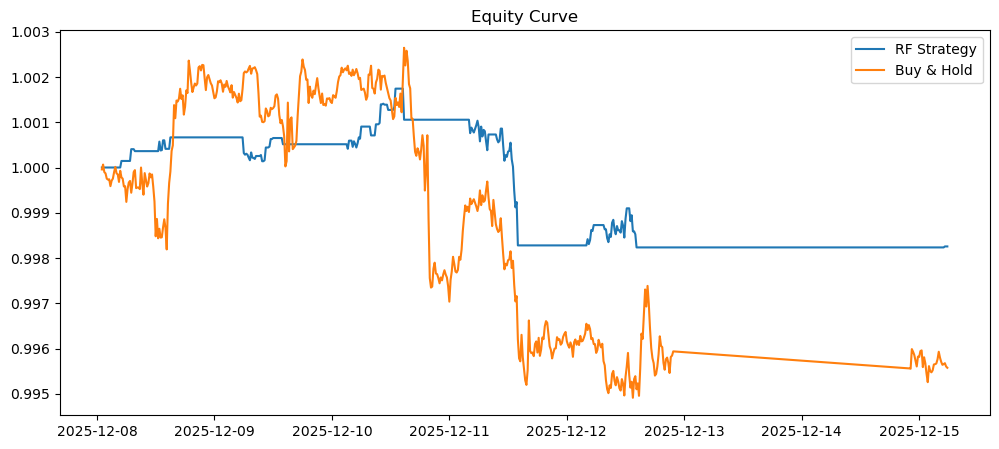

In [120]:
df_test["cum_strategy"] = (1 + df_test["strategy_ret"]).cumprod()
df_test["cum_bh"] = (1 + df_test["log_return"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(df_test.index, df_test["cum_strategy"], label="RF Strategy")
plt.plot(df_test.index, df_test["cum_bh"], label="Buy & Hold")
plt.title("Equity Curve")
plt.legend()
plt.show()


* RF Strategy shows that our model is doing better.
* It is doing well when signal is 0(flat)

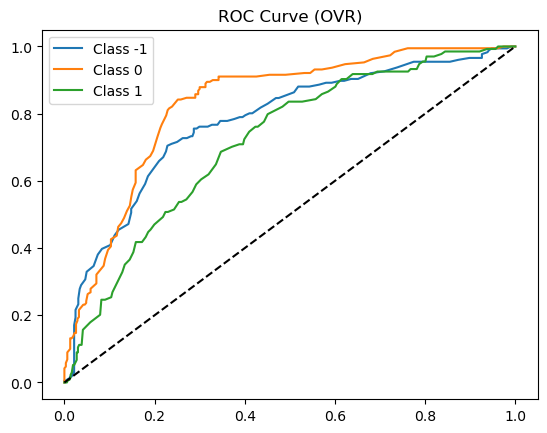

In [124]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y_test, classes=[-1, 0, 1])
probs = rf_final.predict_proba(X_test)

for i, cls in enumerate([-1, 0, 1]):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {cls}")

plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curve (OVR)")
plt.show()


**Class 0 (orange)**

* Highest curve
* Likely AUC ≈ 0.80–0.85
* Model is very good at predicting no-trade
* Very high recall for class 0(0.69)

**Class 1 (green)**

* AUC ≈ 0.65–0.70
* Long signals are hardest to predict

**Class -1 (blue)**

* AUC ≈ 0.72–0.75
* Some signal for shorts
* Model performs moderately on shorts signals.



## `Logistic Regression` model


In [73]:
df_final['target'].unique()

array([ 1, -1,  0], dtype=int8)

In [74]:
df = df_final.copy()

X = df.drop(columns=['target'])
y = df['target']

In [75]:
# Replace infinities
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values using training statistics later

In [76]:
tscv = TimeSeriesSplit(n_splits=5)

In [77]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [78]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        max_iter=200,
        class_weight='balanced',
        n_jobs=-1
    ))
])

In [79]:
all_preds = []
all_true = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fill NaNs using TRAIN medians only (no leakage)
    medians = X_train.median()
    X_train = X_train.fillna(medians)
    X_test  = X_test.fillna(medians)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    all_preds.extend(preds)
    all_true.extend(y_test)

C:\Users\veere\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\veere\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\veere\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\veere\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in versio

In [80]:
print(classification_report(all_true, all_preds))
print(confusion_matrix(all_true, all_preds))

              precision    recall  f1-score   support

          -1       0.42      0.41      0.42     97752
           0       0.51      0.74      0.60     78332
           1       0.47      0.31      0.38    100036

    accuracy                           0.47    276120
   macro avg       0.47      0.49      0.46    276120
weighted avg       0.46      0.47      0.45    276120

[[40227 28459 29066]
 [13782 57831  6719]
 [40888 27731 31417]]


In [81]:
trade_mask = y != 0

X_trade = X[trade_mask]
y_trade = y[trade_mask]

In [82]:
feature_importance = pd.Series(
    model.named_steps['clf'].coef_[0],
    index=X.columns
).sort_values(key=abs, ascending=False)

feature_importance.head(20)

volatility          -0.499205
ATR                  0.345154
hour_cos            -0.310320
EMA_200_D            0.304192
hour_sin             0.284306
ATR_4H               0.133918
price_vs_EMA200_D    0.125481
EMA_200_4H           0.110554
low                 -0.104389
udx_mom_4h           0.094615
ATR_D               -0.090472
ATR_1H               0.089824
ATR_ratio_4H_D      -0.087390
ny_session          -0.073002
open                -0.063404
ATR_ratio_1H_4H     -0.063401
close               -0.061927
EMA_200             -0.056056
EMA_200_1H          -0.049764
us_ca_spread        -0.045681
dtype: float64

C:\Users\veere\AppData\Local\Temp\ipykernel_21768\3808503497.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


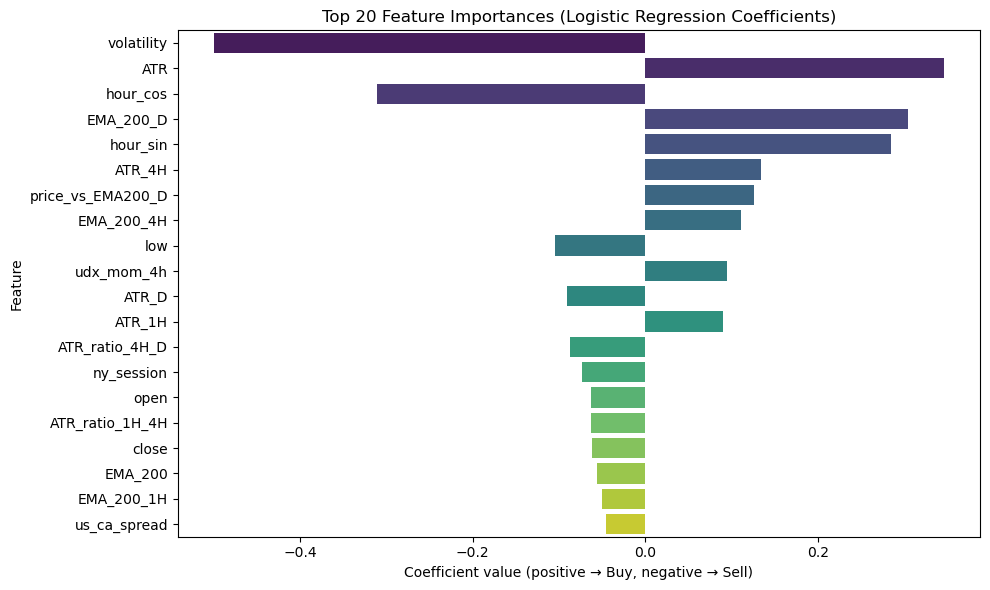

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the same feature_importance Series you already have
top_features = feature_importance.head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 20 Feature Importances (Logistic Regression Coefficients)")
plt.xlabel("Coefficient value (positive → Buy, negative → Sell)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()